# Explainable reasoning with ChiRho (categorical variables)

The **Explainable Reasoning with ChiRho** package aims to provide a systematic, unified approach to causal explanation computations. The package provides a single generic program transformation that can be applied to any arbitrary causal model representable as a Chirho program. This program transformation allows several causal explanation queries to be modeled in terms of probabilistic queries. This approach of reducing causal queries to probabilistic computations on transformed causal models is the foundational idea behind all of ChiRho and in this module, has been leveraged for causal explanations as well.

The goal of this notebook is to illustrate how the package can be used to provide an approximate method of answering a range of causal explanation queries in causal models with only categorical variables. As the key tool will involve sampling-based posterior probability estimation, a lot of what will be said *mutatis mutandis* applies to more general settings where variables are continuous (to which we will devote another tutorial).

In yet [another notebook](https://basisresearch.github.io/chirho/actual_causality.html) we illustrate how the module allows for a faithful reconstruction of a particular notion of local explanation (the so-called Halpern-Pearl modified definition of actual causality [(J. Halpern, MIT Press, 2016)](https://mitpress.mit.edu/9780262537131/actual-causality/)), which inspired some of the conceptual steps underlying the current implementation.

Before proceeding, the readers should go through the introductory tutorials on [causal reasoning in Chirho](https://basisresearch.github.io/chirho/tutorial_i.html). They might also find a notebook on [actual causality](https://basisresearch.github.io/chirho/actual_causality.html) helpful.

**Outline**

[Motivation](#motivation)

[Setup](#setup)

[But-for Causal Explanations](#but-for-causal-explanations)     

[Context-sensitive Causal Explanations](#context-sensitive-causal-explanations)

[Probability of causation and responsibility](#probability-of-causation-and-responsibility)

[Further Discussion](#further-discussion)

# Motivation

Consider the following causality-related queries:

- **Friendly Fire:** On March 24, 2002, A B-52 bomber fired a Joint Direct Attack Munition at a US battalion command post, killing three and injuring twenty special forces soldiers. Out of multiple potential contributing factors, which were actually responsible for the incident?

- **Overshoot:** In dealing with an epidemic, multiple different policies were imposed, leading to the overshoot (the number of those who became infected after the peak of the epidemic) rising from around 15% in the unintervened model to around 25%. Which of the policies caused the overshoot and to what extent?

- **Explainable AI:** Your pre-trial release has been refused based on your [COMPAS score](https://en.wikipedia.org/wiki/COMPAS_(software)). The decision was made using a proprietary predictive model. All you have access to is the questionnaire that was used, and perhaps some demographic information about a class of human beings subjected to this evaluation. But which of these factors resulted in your score being what it is, and what were their contributions?

Questions of this sort are more specific and local as they pertain to actual cases that come with their own contexts, unlike average treatment effects discussed in an earlier [tutorial](https://github.com/BasisResearch/chirho/blob/master/docs/source/tutorial_i.ipynb). Being able to answer such context-sensitive questions is useful for understanding how we can prevent undesirable outcomes and promote desirable ones in contexts similar to the ones in which they had been observed. Moreover, these context-sensitive causality questions are also an essential element of blame and responsibility assignments. 

In this notebook, we demonstrate the use of `SearchForExplanation`, a handler that provides a unified approach to answering such questions on a wide range of levels of granularity.

## Setup

In [21]:
%env CUDA_VISIBLE_DEVICES=-1
from typing import Callable, Dict, List, Optional

import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition
from chirho.observational.handlers.soft_conditioning import soft_eq, KernelSoftConditionReparam

pyro.settings.set(module_local_params=True)

env: CUDA_VISIBLE_DEVICES=-1


We first setup the essentials for performing probabilistic inference on the transformed causal models. We define a function for performing importance sampling on a model and a few other utility functions.

In [22]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc, log_weights

    return _wrapped_model

# The following functions are needed for conditioning on random variables defined using `pyro.deterministic`
def _soft_eq(v1: torch.Tensor, v2: torch.Tensor) -> torch.Tensor:
    return soft_eq(constraints.boolean, v1, v2, scale=0.001)

def reparam_config(data):
    return {i: KernelSoftConditionReparam(_soft_eq) for i in data}

## But-for Causal Explanations

Let's start with a very simple model, in which a forest fire can be caused by any of the two things: a match being dropped (`match_dropped`), or a lightning strike (`lightning`), and either of these factors alone is already deterministically sufficient for the `forest_fire` to occur. A match being dropped is more likely than a lightning strike (we use fairly large probabilities for the sake of example transparency). For illustration, we also include a causally irrelevant site representing whether a ChiRho developer smiles, `smile`. A but-for analysis assigns causal role to a node if it having a different value would result in a different outcome. We will implement this concept and reflect on it in this section.

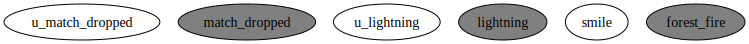

In [23]:
def forest_fire_model():
    u_match_dropped = pyro.sample("u_match_dropped", dist.Bernoulli(0.7))
    match_dropped = pyro.deterministic(
        "match_dropped", u_match_dropped, event_dim=0
    )  # notice uneven probs here

    u_lightning = pyro.sample("u_lightning", dist.Bernoulli(0.4))
    lightning = pyro.deterministic("lightning", u_lightning, event_dim=0)

    # this is a causally irrelevant site
    smile = pyro.sample("smile", dist.Bernoulli(0.5))

    forest_fire = pyro.deterministic(
        "forest_fire", torch.max(match_dropped, lightning) + (0 * smile), event_dim=0
    )

    return {
        "match_dropped": match_dropped,
        "lightning": lightning,
        "forest_fire": forest_fire,
    }

with ExtractSupports() as extract_supports:
    forest_fire_model()
    forest_fire_supports = {k: constraints.boolean for k in extract_supports.supports}

pyro.render_model(forest_fire_model)

Before we further go into causal queries, let us describe some notation. Let $F$ refer to the `forest_fire`, $f$ stand for $F=1$, $f'$ for $F=0$. The notation $M$ stands for `match_dropped`, with analogous conventions. We also place interventions conditioned on in subscripts. As an example, $f_{m'}$ stands for $F=1$ when $do(M=0)$.

Throughout this tutorial, we consider different kinds of causal queries and compute them using a unified program transformation, which takes place using the handler `SearchForExplanation`. It takes the following inputs:
1. the distributions for the variables we use (`supports`),
2. the candidate causes $X_i = x_i$ (`antecedents`),
3. their alternative values ($X_i = x_i'$) (`alternatives`),
4. the candidate elements of the current context (`witnesses`), and  
5. the `consequents` of interest $Y=y$. 

The  `SearchForExplanation` handler then takes these arguments and transforms the original model into another model in which interventions on antecedents and witnesses are applied stochastically. Once the antecedents $A \subseteq$ `antecedents` and witnesses $W \subseteq$ `witnesses` are chosen from the candidates via sampling, parallel counterfactual worlds are created to condition on `A` being sufficient and necessary causes for the consequent with the context `W`. For more details on `SearchForExplanation`, please refer to the [documentation](https://basisresearch.github.io/chirho/explainable.html#chirho.explainable.handlers.explanation.SearchForExplanation).

Now we are ready to use `SearchForExplanation` for answering but-for causal questions.

**Causal Query 1** What is the probability that dropping a match has a causal impact on the forest fire?

To answer the above question, we compute the probability of both the forest fire not occurring if we intervene on the match to not be dropped (the "but-for" part), and the forest fire occurring if we intervene on the match to be dropped, that is, $P(f'_{m'}, f_m)$. This computation can be carried out using `SearchForExplanation`.

The potential cause (`antecedent`) we're considering is `match_dropped=1`. We inspect what would happen if we intervened on it to not happen (`alternatives`), and what happens if we intervene on it to happen, do(`match_dropped=1`). We are interested in whether (and with what probability) an outcome variable `forest_fire` (`consequent`) has both value 0 under the first (this is the "but-for" part) and value 1 under the second intervention. Note that these two interventions correspond to `match_dropped=1` being a necessary and sufficient cause for `forest_fire=1`. In this simple case, the notion corresponds to Pearl's notion of probability of necessity and sufficiency - although what `SearchForExplanation` can do goes beyond it, for instance, by allowing for the estimands to be context-sensitive, as we will illustrate later in this notebook.

In [24]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={}, # potential context elements, we leave them empty for now
    alternatives={"match_dropped": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(forest_fire_model)

logp, trace, mwc, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(0.2987)


The above, strictly speaking, is not our answer yet. Remember that interventions on antecedents are chosen stochastically (with default probability $0.5$ for each candidate node). Thus the above is rather $P(f'_{m'}, f_m)P(m \text{ was intervened on})$. To obtain $P(f'_{m'}, f_m)$ we therefore need to multiply the result by 2, obtaining $0.6$. In general, we don't need to keep track of the analytic solutions, and we can reach the similar conclusion by post-processing the samples to reject those where `match_dropped` was not intervened on. So, without knowing or using an analytic form (which in general will not be manageable), to compute $P(f'_{m'}, f_m)$, we can subselect the samples as follows:

In [25]:
mask_intervened = trace.nodes["__cause____antecedent_match_dropped"]["value"] == 0
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(0.6000)


Note that the result above matches our intuition. `match_dropped` has a causal effect on `forest_fire` only when `lightning` is not there and the probability of that happening is $0.6$.

**Causal Query 2** What is the probability that a Chirho developer has a causal impact on the forest fire?

The intuitive answer is obviously zero, and we show that the same conclusion can be drawn using `SearchForExplanation`.

In [26]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"smile": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={}, 
    alternatives={"smile": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(forest_fire_model)

logp, trace, mwc, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(1.0011e-05)


The above probability is already 0, and the following post-processing does not affect the result. We still provide the following code snippet for the sake of completeness.

In [27]:
mask_intervened = trace.nodes["__cause____antecedent_smile"]["value"] == 0
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(1.0011e-05)


The examples above show how `SearchForExplanation` can be used for but-for analysis. Note, however, that such analysis would not work in a case of overdetermination, where each of the two factors can alone cause the outcome. Consider the case where both `match_dropped` and `lightning` did occur. In this case, if we try to determine the causal role of `match_dropped`, it would come out to be zero (a symmetric reasoning works for lightning as well). This results in $P(f'_{m'}, f_m, m, l) = P(f'_{l'}, f_l, m, l)=0$. This is a canonical example of the limitations of the but-for analysis.

In [28]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"smile": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={}, 
    alternatives={"match_dropped": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(  # We need to reparametrize as we are conditioning on deterministic nodes
    pyro.poutine.reparam(config=reparam_config(["match_dropped", "lightning"]))(
        condition(data={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)})
            (forest_fire_model)
    ))

logp, trace, mwc, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(2.8055e-06)


In [29]:
mask_intervened = trace.nodes["__cause____antecedent_match_dropped"]["value"] == 0
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(2.7924e-06)


One thing we can do, is to consider the set containing both `match_dropped` and `lightning`. Then we can estimate $P(f'_{m',l'}, f_{m,l}, m, l)$ to determine their joint causal role, which comes out to be greater than 0, as follows.

In [30]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={},
    alternatives={"match_dropped": torch.tensor(0.0), "lightning": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(
    pyro.poutine.reparam(config=reparam_config(["match_dropped", "lightning"]))(
        condition(data={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)})
            (forest_fire_model)
    ))

logp, trace, mwc, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(0.0670)


Now to get our estimand of $P(f_{m, l}, f_{m', l'}, m, l)$, we would need to multiply our result by four, as we now have made two stochastic decisions about interventions, each with probability $0.5$. Or, we can post-process the sample:

In [31]:
mask_intervened = (trace.nodes["__cause____antecedent_match_dropped"]["value"] == 0) & (trace.nodes["__cause____antecedent_lightning"]["value"] == 0)
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(0.2772)


This again matches our intuition. Conditioning brings the factivity requirement into the picture, and so now what we are estimating is the probability of `m` and `l` in fact happening *and* having a causal impact on the forest fire. Since in general, the two-element set has deterministically complete control over the forest fire, the only non-trivial probability is the one brought in by the factivity requirement - the probability of both `match_dropped=1` and `lightning=1`, which is $0.28$.

One might also be interested in computing the causal impact of the set without factoring in the factivity requirement, so that the result mirrors the intuition that the two-element set has complete control over the outcome. To get to this point, one can compute $P(f_{m, l}, f'_{m', l'} | m, l)$ as follows by subselecting the samples with `match_dropped=1` and `lightning=1`. Since {`match_dropped=1`, `lightning=1`} always leads to `forest_fire=1` and {`match_dropped=0`, `lightning=0`} always leads to `forest_fire=0`, we have $P(f_{m, l}, f'_{m', l'} | m, l) = 1$, which we get as a result of the following code snippet.

Note that $P(f_{m, l}, f'_{m', l'} | m, l)$ can also be computed as $\frac{P(f_{m, l}, f'_{m', l'}, m, l)}{P(m, l)}$ which requires computing $P(m, l)$ using the original `forest_fire_model`.

In [32]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={},
    alternatives={"match_dropped": torch.tensor(0.0), "lightning": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(forest_fire_model)

logp, trace, mwc, log_weights = importance_infer(num_samples=10000)(query)()

mask_intervened = (trace.nodes["__cause____antecedent_match_dropped"]["value"] == 0) & (trace.nodes["__cause____antecedent_lightning"]["value"] == 0) & (trace.nodes["match_dropped"]["value"] == 1) & (trace.nodes["lightning"]["value"] == 1)
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(1.0000)


## Context-sensitive Causal Explanations

As the previous example showed, the but-for analysis is not sufficient for identifying causal roles. This induces the need to pay attention to the membership of variables in larger antecedent sets that would make a difference (that is one reason why we need stochasticity in the antecedent candidate preemption: to search for such sets). But even then, the but-for analysis does not pay sufficient attention to the granularity of a given problem and its causal structure. There are asymmetric cases where the efficiency of one cause prevents the efficiency of another, in which our causal attributions should a be asymmetric, but "being a member of the same larger antecedent set" isn't. We illustrate using a simple example.

Consider the example of breaking a bottle. Suppose Sally and Bob throw a rock at a bottle, and Sally does so a little earlier than Bob. Suppose both are perfectly accurate, and the bottle shatters when hit. Sally hits, and the bottle shatters, but Bob doesn't hit it because the bottle is no longer there.

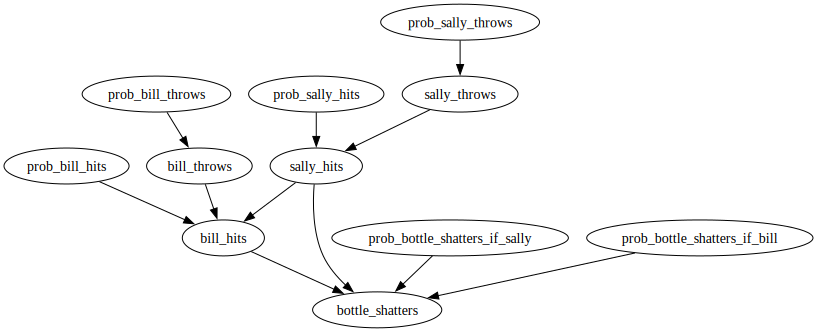

In [33]:
def stones_model():
    prob_sally_throws = pyro.sample("prob_sally_throws", dist.Beta(1, 1))
    prob_bill_throws = pyro.sample("prob_bill_throws", dist.Beta(1, 1))
    prob_sally_hits = pyro.sample("prob_sally_hits", dist.Beta(1, 1))
    prob_bill_hits = pyro.sample("prob_bill_hits", dist.Beta(1, 1))
    prob_bottle_shatters_if_sally = pyro.sample(
        "prob_bottle_shatters_if_sally", dist.Beta(1, 1)
    )
    prob_bottle_shatters_if_bill = pyro.sample(
        "prob_bottle_shatters_if_bill", dist.Beta(1, 1)
    )

    sally_throws = pyro.sample("sally_throws", dist.Bernoulli(prob_sally_throws))
    bill_throws = pyro.sample("bill_throws", dist.Bernoulli(prob_bill_throws))

    # if Sally throws, she hits with probability prob_sally_hits
    # hits with pr=0 otherwise
    new_shp = torch.where(sally_throws == 1, prob_sally_hits, 0.0)

    sally_hits = pyro.sample("sally_hits", dist.Bernoulli(new_shp))

    # if Bill throws, he hits with probability prob_bill_hits
    # if sally doesn't hit sooner,
    # misses otherwise
    new_bhp = torch.where(
        bill_throws.bool() & (~sally_hits.bool()),
        prob_bill_hits,
        torch.tensor(0.0),
    )

    bill_hits = pyro.sample("bill_hits", dist.Bernoulli(new_bhp))

    # you can use a analogous move to model the bottle shattering
    # if being hit by a stone doesn't deterministically
    # shatter the bottle
    new_bsp = torch.where(
        bill_hits.bool(),
        prob_bottle_shatters_if_bill,
        torch.where(
            sally_hits.bool(),
            prob_bottle_shatters_if_sally,
            torch.tensor(0.0),
        ),
    )

    bottle_shatters = pyro.sample("bottle_shatters", dist.Bernoulli(new_bsp))

    return {
        "sally_throws": sally_throws,
        "bill_throws": bill_throws,
        "sally_hits": sally_hits,
        "bill_hits": bill_hits,
        "bottle_shatters": bottle_shatters,
    }


with ExtractSupports() as extract_supports:
    stones_model()
    stones_supports = {k: constraints.boolean if not k.startswith("prob_") else v for k, v in extract_supports.supports.items()}

pyro.render_model(stones_model)

For now let us assume that the relevant probabilities are 1 (this forces both Sally and Bill to throw stones, makes them perfectly accurate and makes the bottle always shatter if hit). Let us start with the type of analysis we performed for the forest fire case. 

In [34]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"sally_throws": torch.tensor(1.0)},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={},
    alternatives={"sally_throws": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(condition(
    data={
        "prob_sally_throws": torch.tensor(1.0),
        "prob_bill_throws": torch.tensor(1.0),
        "prob_sally_hits": torch.tensor(1.0),
        "prob_bill_hits": torch.tensor(1.0),
        "prob_bottle_shatters_if_sally": torch.tensor(1.0),
        "prob_bottle_shatters_if_bill": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(1.0013e-05)


In [35]:
mask_intervened = trace.nodes["__cause____antecedent_sally_throws"]["value"] == 0
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(1.0013e-05)


Sally's throw does not satisfy the but-for condition: if she hadn't thrown the rock, the bottle would still have shattered. Of course, the combined event of Sally throwing a rock and Bob throwing a rock is a but-for cause of the bottle shattering. But that doesn't capture the clear asymmetry at work here. Intuitively, Sally's throw is the (actual) cause of the bottle breaking in a way that Bob's throw isn't.  Sally's throw actually caused the bottle to shatter and Bob's throw didn't, in part because Bob's stone didn't actually hit the bottle.

An intuitive solution to the problem, inspired by the  Pearl-Halpern definition of actual causality (which we discuss in [another notebook](https://basisresearch.github.io/chirho/actual_causality.html)) is to say that **in answering actual causality queries, we need to consider what happens when part of the actual context is kept fixed.** For instance, in the bottle shattering example, given the observed fact that Bob’s stone didn’t hit, in the counterfactual world in which we keep this observed fact fixed, if Sally had not thrown the stone, the bottle in fact would not have shattered. 


For this reason, our handler allows not only stochastic preemption of interventions (to approximate the search through possible antecedent sets) but also stochastic witness preemption of those nodes that are considered part of the context (these needn't exclude each other). In a witness preemption, we ensure that the counterfactual value is identical to the factual one (and by applying it randomly to candidate witness nodes, we approximate a search through all possible context sets).

In [36]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"sally_throws": torch.tensor(1.0)},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={"bill_hits": None},
    alternatives={"sally_throws": torch.tensor(0.0)},
    consequent_scale=1e-5
)(condition(
    data={
        "prob_sally_throws": torch.tensor(1.0),
        "prob_bill_throws": torch.tensor(1.0),
        "prob_sally_hits": torch.tensor(1.0),
        "prob_bill_hits": torch.tensor(1.0),
        "prob_bottle_shatters_if_sally": torch.tensor(1.0),
        "prob_bottle_shatters_if_bill": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc, log_weights = importance_infer(num_samples=100000)(query)()
print(torch.exp(logp))

tensor(0.2513)


In [37]:
mask_intervened = trace.nodes["__cause____antecedent_sally_throws"]["value"] == 0
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(0.5019)


Admittedly, our search through contexts is simple as the only part of the actual context which stochastically is kept fixed at the factual value is `bill_hits`. But already with this search, Sally's throw is diagnosed as having impact on the bottle shattering with non-null probability. In fact, the definition of actual causality in Halpern's book (*Actual causality*) contains an existential quantifier: a variable is an actual cause if there is at least one context in which a change in the outcome variable would result from changing the antecedent to have an alternative value, so our search provides a correct diagnosis here.

Crucially, as intended, an analogous inference for whether `bill_throws` is a cause of the bottle shattering, yields a different result and assigns null causal role to Bill's throw.

In [38]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"bill_throws": torch.tensor(1.0)},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={"sally_hits": None},
    alternatives={"bill_throws": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(condition(
    data={
        "prob_sally_throws": torch.tensor(1.0),
        "prob_bill_throws": torch.tensor(1.0),
        "prob_sally_hits": torch.tensor(1.0),
        "prob_bill_hits": torch.tensor(1.0),
        "prob_bottle_shatters_if_sally": torch.tensor(1.0),
        "prob_bottle_shatters_if_bill": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(1.0013e-05)


In [39]:
mask_intervened = trace.nodes["__cause____antecedent_bill_throws"]["value"] == 0
print(torch.sum(torch.exp(log_weights) * mask_intervened.squeeze())/torch.sum(mask_intervened.float()))

tensor(1.0013e-05)


## Probability of Causation and Responsibility

In the examples above, we have shown how `SearchForExplanation` can be used to perform but-for analysis and context-sensitive analysis. In this section, we extend how we can combine these queries ina single model and perform more involved queries about probabilities of causation and responsibility.

We take the earlier defined `stones_model` with non-trivial probabilities and the single observation that the bottle was shattered. We do not know who threw the stone and thus it is not obvious what context to hold fixed. We can capture all these different possibilities using the single program transformation performed by `SearchForExplanation` and post-process the samples to answer different queries.

In [40]:
query = SearchForExplanation(
    supports=stones_supports,
    antecedents={"sally_throws": torch.tensor(1.0), "bill_throws": torch.tensor(1.0)},
    consequents={"bottle_shatters": torch.tensor(1.0)},
    witnesses={"bill_hits": None, "sally_hits": None},
    alternatives={"sally_throws": torch.tensor(0.0), "bill_throws": torch.tensor(0.0)},
    consequent_scale=1e-5
)(condition(
    data={
        "prob_sally_throws": torch.tensor(0.8),
        "prob_bill_throws": torch.tensor(0.7),
        "prob_sally_hits": torch.tensor(0.9),
        "prob_bill_hits": torch.tensor(0.8),
        "prob_bottle_shatters_if_sally": torch.tensor(0.9),
        "prob_bottle_shatters_if_bill": torch.tensor(0.8),
        "bottle_shatters": torch.tensor(1.0),
    }
)(stones_model))

logp, trace, mwc, log_weights = importance_infer(num_samples=100000)(query)()
print(torch.exp(logp))

tensor(0.1543)


Now we show how our earlier analysis on the `stones_model` can be carried out through some analysis on the samples we get through this model where we have both `sally_throw` and `bill_throws` as candidate causes and both `bill_hits` and `sally_hits` as context nodes.

We first compute the probability of causation for `sally_throws`. We compute the probability that the set {`sally_throws=1`} is the cause of bottle shattering.

In [27]:
mask_intervened = (trace.nodes["__cause____antecedent_sally_throws"]["value"] == 0) & (trace.nodes["__cause____antecedent_bill_throws"]["value"] == 1)
print(torch.sum(torch.exp(log_weights) * mask_intervened.float().squeeze())/mask_intervened.float().sum())

tensor(0.2195)


We similarly compute this probability for `bill_throws`.

In [28]:
mask_intervened = (trace.nodes["__cause____antecedent_sally_throws"]["value"] == 1) & (trace.nodes["__cause____antecedent_bill_throws"]["value"] == 0)
print(torch.sum(torch.exp(log_weights) * mask_intervened.float().squeeze())/mask_intervened.float().sum())

tensor(0.0667)


We can also use the same model as above to compute the degree of responsibility for bill and sally as follows. We interpret the degree of responsibility assigned to sally for bottle shattering as the probability that `sally_throws=1` is part of the cause. Similarly, the degree of responsibility assigned to billy for shattering the bottle is the probability that `billy_throws=1` is a part of the cause.

In [29]:
mask_intervened = (trace.nodes["__cause____antecedent_sally_throws"]["value"] == 0)
print(torch.sum(torch.exp(log_weights) * mask_intervened.float().squeeze())/mask_intervened.float().sum())

tensor(0.2777)


In [30]:
mask_intervened = (trace.nodes["__cause____antecedent_bill_throws"]["value"] == 0)
print(torch.sum(torch.exp(log_weights) * mask_intervened.float().squeeze())/mask_intervened.float().sum())

tensor(0.2014)


Note that we assumed Sally to be more likely to throw, more likely to hit, and more likely to shatter the bottle if she hits. For this reason, we expect her to be more likely to be causally responsible for the outcome and that is the result we got. Conceptually, these estimates are impacted by some hyperparameters, such as witness preemption probabilities, so perhaps a bit more clarity on can be gained if we think we have a complete list of potential causes and normalize. 

# Further Discussion

In this notebook, we have shown how `SearchForExplanation` can be used for fine-grained causal queries for discrete causal models. We further elaborate on its application in for different queries. 

**Explainable AI**: If the phenomenon we're trying to explain is the behavior of a predictive model, we are dealing with a problem in explainable AI; but the underlying intuition behind the workings of **Explainable Reasoning with ChiRho** is that causally explaining the behavior of an opaque model is not that much different from providing a causal explanation of other real-world phenomena: we need to address such queries in a principled manner employing some approximate but hopefully reliable causal model of how things work (be that events outside of computers, or a predicitive model's behavior). **Explainable Reasoning with ChiRho** package aims to provide a unified general approach to the relevant causal explanation computations. At least a few major approaches to explainable AI (such as [LIME](https://arxiv.org/abs/1602.04938),  or [Shapley values](https://papers.nips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html))  are based on the idea that explanations can be obtained by perturbing or shifting the input values and observing the changes in the output. This to a large extent can be thought of as a way of evaluating the but-for condition: if the input value was different, would the output value change? 

**Other Applications**: Causal queries, specifically but-for tests are often used in [the law of torts](https://plato.stanford.edu/entries/causation-law/) to determine if a defendant's conduct was the cause of a particular harm. The test is often formulated as follows: "But for the defendant's conduct, would the harm have occurred?". A major philosophical position in the analysis of causality is that the definition of causal dependence should be formulated in terms of counterfactual conditionals (Lewis, 1973. “Causation”, Journal of Philosophy, 70: 556–67). On this approach, $e$ causally depends on $c$ if and only if, if $c$ were not to occur $e$ would not occur. (The view does not remain uncontested, see the [SEP entry on counterfactual theories of causation](https://plato.stanford.edu/entries/causation-counterfactual/)).